In [1]:
# Read the Dataframe
import pandas as pd

df = pd.read_excel('../data/cleaned_v2.xlsx')
df = df.set_index('Department')

# Group by and display count for each category
# There are 11 categories of complaints
df.groupby(df.index).count()

,Description
Department,
Building Permission,2119
Drainage,2132
Electrical,4037
Encroachment,1470
Garbage,16932
Garden,1653
Health,2802
Property Tax,1491
Road,5510


In [2]:
# Make a dataset for training
# We are sampling 4000 entries per category, 
# thus minority classes are oversampled, ensuring that there is no imbalance in the dataset

# Q. What is the need to do this? 
# A. To resolve the bottleneck of having too few entries for some classes ~ 1400 
#    as well as too much for some classes ~16k. I have taken the number of samples as tunable,
#    and I arrived at the number 4000 just by hit and trial.

# STATE is used for producing replicable results
df_for_training = pd.DataFrame()
SAMPLES = 4000
STATE = 0

for i in list(set(df.index)):
    df_for_training = df_for_training.append(df.loc[i].sample(n=SAMPLES,random_state=STATE,replace=True))

df_for_training['class_label'] = df_for_training.index.factorize()[0]

In [3]:
df_for_training

,Description,class_label
Department,,
Encroachment,chowka madhe food stall lagle aahet.,0
Encroachment,Hawkers issue,0
Encroachment,Beggars are living under chatursungi bridge a...,0
Encroachment,This fruit and vegetable vendor is putting his...,0
Encroachment,Encroachment on Common Lane:-We are owner of p...,0
...,...,...
Garbage,Garbage dump,10
Garbage,Garbage dump,10
Garbage,Garbage vehicle not arrived,10


In [4]:
# Since the classes are now numbered, I am storing this in a mapper.
import json

mapper = {}
for i,j in enumerate(list(set(df_for_training.index))):
    mapper[i] = j


with open("../data/mapper.json", "w") as outfile:  
    json.dump(mapper, outfile) 


In [5]:
# importing libraries for the model

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


import re
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/manpreet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Initializing the stemmer, stopwords and the vectorizer

stemmer = PorterStemmer()
words = stopwords.words("english")
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True)


In [7]:
# Creating the input set by renaming columns and shuffling

X = df_for_training.copy() # Deep copy
X.columns = ['text','label']
X.index.name = None
X = X.reset_index()
X = X[['text','label']]
X = X.sample(frac=1)

In [8]:
X

,text,label
3233,My Client Shri. Ghanshyam Chunilal Surana prop...,0
23214,Name : Premila Salunke. Mob no : 955 4 161.,5
5356,Sweeping not done,1
16394,In our lane road is very short in the width. F...,4
37929,While coming from Dapodi once u cross the Harr...,9
...,...,...
5127,You have closed complaint W3 947 without any a...,1
25186,chaukoni chamber saf karane.,6
41648,Garbage dump,10
34044,Update property tax amount,8


In [9]:
# Creating the train-test split 
X['cleaned'] = X['text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

x = X['cleaned']
y = X['label']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

Y_test = np.array(y_test)

In [10]:
# Initializing the models
models = {
            'RandomForest' : RandomForestClassifier(n_estimators=400,n_jobs=4),
            'LinearSVC' : LinearSVC(),
            'MultinomialNB' : MultinomialNB(),
            'LogisticRegression' : LogisticRegression(max_iter=200)
         }

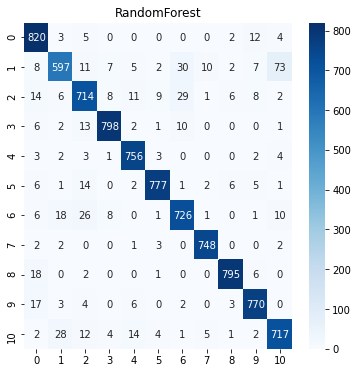

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       846
           1       0.90      0.79      0.84       752
           2       0.89      0.88      0.89       808
           3       0.97      0.96      0.96       833
           4       0.95      0.98      0.96       774
           5       0.97      0.95      0.96       815
           6       0.91      0.91      0.91       797
           7       0.98      0.99      0.98       758
           8       0.98      0.97      0.97       822
           9       0.95      0.96      0.95       805
          10       0.88      0.91      0.89       790

    accuracy                           0.93      8800
   macro avg       0.93      0.93      0.93      8800
weighted avg       0.93      0.93      0.93      8800



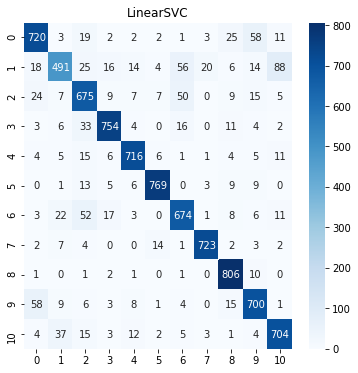

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       846
           1       0.84      0.65      0.73       752
           2       0.79      0.84      0.81       808
           3       0.92      0.91      0.91       833
           4       0.93      0.93      0.93       774
           5       0.96      0.94      0.95       815
           6       0.83      0.85      0.84       797
           7       0.96      0.95      0.96       758
           8       0.90      0.98      0.94       822
           9       0.85      0.87      0.86       805
          10       0.84      0.89      0.87       790

    accuracy                           0.88      8800
   macro avg       0.88      0.88      0.88      8800
weighted avg       0.88      0.88      0.88      8800



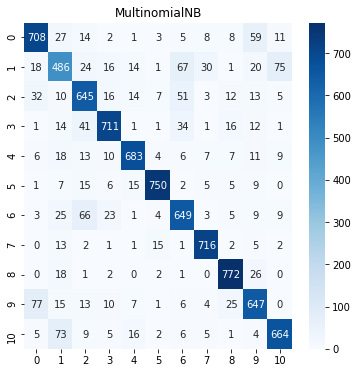

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       846
           1       0.69      0.65      0.67       752
           2       0.77      0.80      0.78       808
           3       0.89      0.85      0.87       833
           4       0.91      0.88      0.89       774
           5       0.95      0.92      0.93       815
           6       0.78      0.81      0.80       797
           7       0.92      0.94      0.93       758
           8       0.90      0.94      0.92       822
           9       0.79      0.80      0.80       805
          10       0.86      0.84      0.85       790

    accuracy                           0.84      8800
   macro avg       0.84      0.84      0.84      8800
weighted avg       0.84      0.84      0.84      8800



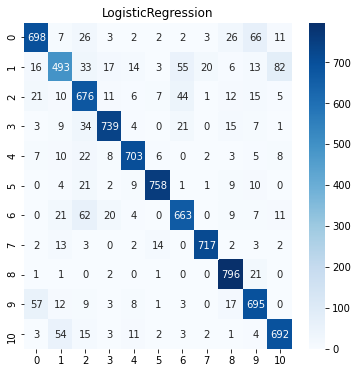

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       846
           1       0.78      0.66      0.71       752
           2       0.75      0.84      0.79       808
           3       0.91      0.89      0.90       833
           4       0.92      0.91      0.91       774
           5       0.95      0.93      0.94       815
           6       0.84      0.83      0.83       797
           7       0.96      0.95      0.95       758
           8       0.89      0.97      0.93       822
           9       0.82      0.86      0.84       805
          10       0.85      0.88      0.86       790

    accuracy                           0.87      8800
   macro avg       0.87      0.87      0.87      8800
weighted avg       0.87      0.87      0.87      8800



In [11]:
accuracies = {}
for model_name in list(models.keys()):
    pipeline = Pipeline([('vect', vectorizer),
                         ('chi',  SelectKBest(chi2, k=1000)),
                         ('clf', models[model_name])])

    model = pipeline.fit(X_train, y_train)
    with open(f'{model_name}.pickle', 'wb') as f:
        pickle.dump(model, f)
        
    
    plt.figure(figsize=(6,6))
    plt.title(model_name)
    sns.heatmap(confusion_matrix(Y_test, model.predict(X_test)),annot=True,fmt='',cmap='Blues')
    plt.show()
    
    accuracies[model_name] = "{:.2f}".format(model.score(X_test, Y_test) * 100)
    print(classification_report(Y_test, model.predict(X_test)))

In [12]:
accuracies

{'RandomForest': '93.39',
 'LinearSVC': '87.86',
 'MultinomialNB': '84.44',
 'LogisticRegression': '86.70'}

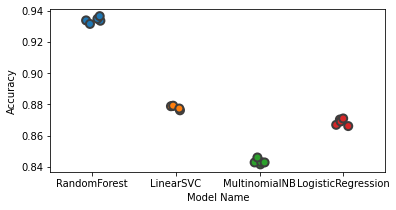

In [13]:
# Performing 5-fold cross validation for better selection of the model best suited

pipelines = {}
for model_name in list(models.keys()):
    pipelines[model_name] = Pipeline([('vect', vectorizer),
                         ('chi',  SelectKBest(chi2, k=1000)),
                         ('clf', models[model_name])])

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model_name, model in pipelines.items():
    accuracies = cross_val_score(model, x, y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['Model Name', 'fold_idx', 'Accuracy'])

plt.figure(figsize=(6,3))
sns.stripplot(x='Model Name', y='Accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()